## Overview

In this section, we will learn the basics of querying cloud-hosted data via [STAC](https://stacspec.org/en) and leverage parallel computing via [Dask](https://tutorial.xarray.dev/intermediate/xarray_and_dask.html).

We will learn how to query a catalog of Sentinel-2 images to find the least-cloudy scene over a chosen area, visualize it and download it as a GeoTIFF file.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client odc-stac rioxarray dask jupyter-server-proxy

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import pystac_client
from odc import stac
import xarray as xr
import rioxarray as rxr

## Dask

[`Dask`](https://www.dask.org/) is a python library to run your computation in parallel across many machines. Dask has built-in support for key geospatial packages like XArray and Pandas allowing you to scale your computation easily. You can choose to run your code in parallel on your laptop, a machine in the cloud, local or cloud cluster of machines etc.

In [ ]:
from dask.distributed import Client
client = Client()  # set up local cluster on the machine
client

If you are running this notebook in Colab, you will need to create and use a proxy URL to see the dashboard running on the local server.

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    port_to_expose = 8787  # This is the default port for Dask dashboard
    print(output.eval_js(f'google.colab.kernel.proxyPort({port_to_expose})'))


## Spatio Temporal Asset Catalog (STAC)

Spatio Temporal Asset Catalog (STAC) is an open standard for specifying and querying geospatial data. Data provider can share catalogs of satellite imagery ,climate datasets, LIDAR data, vector data etc. and specify asset metadata according to the STAC specifications. All STAC catalogs can be queried to find matching assets by time, location or metadata.


You can browse all available catalogs at https://stacindex.org/


Let's use [Earth Search by Element 84](https://stacindex.org/catalogs/earth-search#/) STAC API Catalog to look for items from the sentinel-2-l2a collection on AWS.


In [ ]:
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

We define a location and time of interest to get some satellite imagery.

In [ ]:
latitude = 27.163
longitude = 82.608
year = 2023

In [ ]:
# Define a small bounding box around the chosen point
km2deg = 1.0 / 111
x, y = (longitude, latitude)
r = 1 * km2deg  # radius in degrees
bbox = (x - r, y - r, x + r, y + r)

Search the catalog for matching items.

In [ ]:
search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}'
)
items = search.item_collection()
items

We can apply some additional metadata filters to look for images with less cloud cover and granules with less nodata pixels.

In [ ]:
search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover': {'lt': 30}, 's2:nodata_pixel_percentage': {'lt': 10}}
)
items = search.item_collection()
items

We can also sort the results by some metadata. Here we sort by cloud cover.

In [ ]:
search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover': {'lt': 30}, 's2:nodata_pixel_percentage': {'lt': 10}},
    sortby=[{'field': 'properties.eo:cloud_cover', 'direction': 'asc'}]

)
items = search.item_collection()
items

## Load STAC Images to XArray

Load the matching images as a XArray Dataset.

In [ ]:
ds = stac.load(
    items,
    bands=['red', 'green', 'blue', 'nir'],
    resolution=10,
    chunks={},  # <-- use Dask
    groupby='solar_day',
    preserve_original_order=True
)
ds

Use[ `xarray.Dataset.nbytes`](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.nbytes.html) property to check the size of the loaded dataset.

In [ ]:
print(f'DataSet size: {ds.nbytes/1e6:.2f} MB.')

## Select a Single Scene

Let's work with a single scene for now. We will use the first item from our search (the least cloudy scene). When the items are loaded as a XArray Dataset, the `time` dimension is sorted. We get the timestamp of the least cloudy scene and select it from the dataset.

In [ ]:
timestamp = pd.to_datetime(items[0].properties['datetime']).tz_convert(None)
scene = ds.sel(time=timestamp)
scene

In [ ]:
print(f'Scene size: {scene.nbytes/1e6:.2f} MB.')

This scene is small enough to fit into RAM, so let's call `compute()` to load this into memory. Dask will query the cloud-hosted dataset to fetch the required pixels. As we setup a Dask LocalCluster, the process will be paralellized across all available cores of the machine. Once you run the cell, look at the Dask Diagnostic Dashboard to see the data processing in action.

In [ ]:
%%time
scene = scene.compute()

In [ ]:
scene

The Sentinel-2 scenes come with NoData value of 0. So we set the correct NoData value before further processing.

In [ ]:
scene = scene.where(scene != 0)
scene

Each band of the scene is saved with integer pixel values (data type `uint16`). This help save the storage cost as storing the reflectance values as floating point numbers (data type `float64`) requires more storage. We need to convert the raw pixel values to reflectances by applying the *scale* and *offset* values. The [Earth Search STAC API](https://github.com/Element84/earth-search) does not apply the scale/offset automatically to Sentinel-2 scene and they are supplied in the `raster:bands` metadata for each band. The scale and offset for sentinel-2 scenes captured after Jan 25, 2022 is `0.0001` and `-0.1` respectively.

In [ ]:
scale = 0.0001
offset = -0.1
scene = scene*scale + offset

## Visualize the Scene

To visualize our Dataset, we first convert it to a DataArray using the `to_array()` method. All the variables will be converted to a new dimension. Since our variables are image bands, we give the name of the new dimesion as band.


In [ ]:
scene_da = scene.to_array('band')
scene_da

We can create a low-resolution preview by resampling the DataArray from its native resolution. The raster metadata is stored in the [rio accessor](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors). This is enabled by the `rioxarray` library which provides geospatial functions on top of xarray.

In [ ]:
print('CRS:', scene_da.rio.crs)
print('Resolution:', scene_da.rio.resolution())

This is a fairly large scene with a lot of pixels. For visualizing, we resample it to a lower resolution preview. When plotting the image, the `robust=True` option applies a *98-percentile* stretch to find the optimal min/max values for visualization.

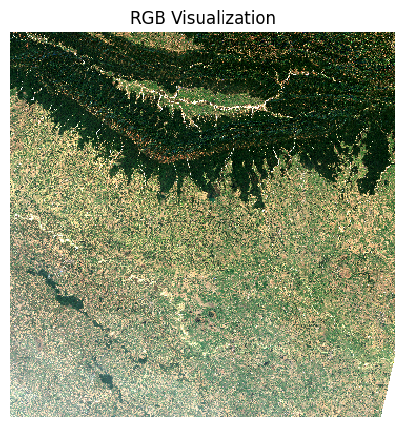

In [23]:
preview = scene_da.rio.reproject(
    scene_da.rio.crs, resolution=300
)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
preview.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
ax.set_aspect('equal')
plt.show()

## Exercise

The `items` variable contains a list of STAC Items returned by the query. The code below iterates through each item and print its metadata stored in the `properties`. Extract the Sentinel-2 Product ID stored in `s2:product_uri` peroperty and print a list of all image ids returned by the query.

In [ ]:
for item in items:
  print(item.properties)